In [2]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..\..'))
	print(os.getcwd())
except:
	pass


C:\Users\joris


In [3]:
import os
try:
	os.chdir(os.path.join(os.getcwd(), 't1d-prediction\data'))
	print(os.getcwd())
except:
	pass


In [4]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


 ## Load Data from csv Sheet

In [5]:
data = pd.read_csv("csv/data_full.csv")
data.head()


FileNotFoundError: File b'csv/data_full.csv' does not exist

 Our data has 28 columns, we only need a few so we remove all unnecessary columns

In [1]:
to_drop =   [ 'cgmRawValue','cgmAlertValue', 'pumpCgmPredictionValue', 'basalAnnotation', 'bolusCalculationValue',
            'heartRateVariabilityValue', 'stressBalanceValue', 'stressValue', 'sleepValue', 'sleepAnnotation', 'locationAnnotation',
            'mlCgmValue','mlAnnotation','insulinSensitivityFactor','otherAnnotation', 'pumpAnnotation', 'exerciseTimeValue',
            'exerciseAnnotation', 'heartRateValue'
            ]

data.drop(to_drop, inplace=True, axis=1)
data.head()

NameError: name 'data' is not defined

 We keep 9 columns
 Next we will combine the date and time column to a datetime object

In [6]:
timeFormat = "%d.%m.%y,%H:%M%z"
timeZone = "+0100"
data["datetimeIndex"] = data.apply(lambda row: datetime.datetime.strptime((row.date + ',' + row.time) + timeZone, timeFormat), axis=1)
data.head()



,date,time,bgValue,cgmValue,glucoseAnnotation,basalValue,bolusValue,bolusAnnotation,mealValue,datetimeIndex
0,01.01.10,05:05,237.0,NaN,GLUCOSE_BG:CGM_VENDOR_MEDTRONIC:GLUCOSE_CGM_CA...,NaN,NaN,NaN,NaN,2010-01-01 05:05:00+01:00
1,01.01.10,05:06,NaN,NaN,NaN,NaN,2.6,BOLUS_NORMAL,NaN,2010-01-01 05:06:00+01:00
2,01.01.10,17:14,143.0,NaN,GLUCOSE_BG_MANUAL:CGM_VENDOR_MEDTRONIC:GLUCOSE...,NaN,NaN,NaN,NaN,2010-01-01 17:14:00+01:00
3,01.01.10,20:08,341.0,NaN,CGM_VENDOR_MEDTRONIC:GLUCOSE_CGM_CALIBRATION=3...,NaN,NaN,NaN,NaN,2010-01-01 20:08:00+01:00
4,01.01.10,20:09,NaN,NaN,NaN,NaN,15.7,BOLUS_NORMAL,1.5,2010-01-01 20:09:00+01:00


 ## let's analyze the cgmValue
 First we print the cgmValue over the timeindex to visulize the data

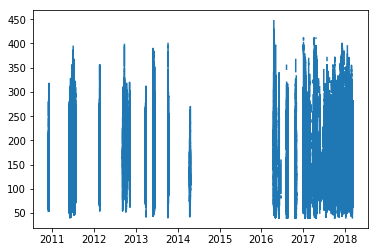

In [7]:
plt.plot(data['datetimeIndex'], data['cgmValue']) 


 we see some missing parts, we therefore need to fill them
 we can interpolate the missing values if the gaps are not too large
 we will now calculate the time gaps between two measurements

count    118072.000000
mean          7.068077
std          16.732992
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max        1381.000000
dtype: float64


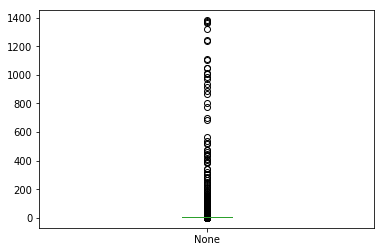

In [8]:
cgmtrue = data[data['cgmValue'].notnull()]
cgmtrue_datetime = cgmtrue['datetimeIndex']
deltas = []
gaps = []
for i in range(len(cgmtrue_datetime) - 1):
    delta = (cgmtrue_datetime[i+1] - cgmtrue_datetime[i]).seconds / 60
    if delta > 20:
        gaps.append(cgmtrue_datetime[i])
    deltas.append((cgmtrue_datetime[i+1] - cgmtrue_datetime[i]).seconds / 60)

deltas = pd.Series(deltas)
print(deltas.describe())
deltas.plot.box()



 we see that the mean is around 5 minutes between two measurements
 but in the plot we see that we have some outliers, with the maximum delta of almost a day.
 That is definitely to long too interpolate between these points
 lets look closer at the outliers

6.0          17
8.0           2
10.0        140
12.0          1
14.0        290
15.0      18176
16.0       1092
17.0        129
18.0         17
19.0          7
20.0         28
21.0          1
24.0          1
25.0         25
29.0          1
30.0         30
31.0          5
32.0          2
33.0          1
34.0          2
35.0          6
40.0         10
45.0         10
46.0          1
47.0          3
48.0          3
49.0          1
50.0          5
55.0          5
56.0          1
          ...  
458.0         1
474.0         1
476.0         1
518.0         1
526.0         1
540.0         1
565.0         1
684.0         1
701.0         1
778.0         1
800.0         1
865.0         1
890.0         1
918.0         1
934.0         1
971.0         1
985.0         1
1005.0        1
1015.0        1
1046.0        1
1048.0        1
1105.0        1
1112.0        1
1237.0        1
1246.0        1
1323.0        1
1365.0        1
1367.0        1
1377.0        1
1381.0        1
Length: 138, dtype: int6

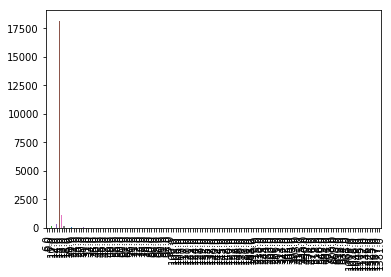

In [9]:
outlier = deltas[deltas > 5]
outlier_counts = outlier.value_counts().sort_index()
outlier_counts.plot.bar()
print(outlier_counts)
print("total " + str(outlier_counts.sum()))


 We have a total of 20160 gaps which are more than 5 minutes
 if we interpolate up to 20 minutes we over most of these

In [10]:
outlier_more_than_20 = outlier[outlier > 20]
outlier_20_counts = outlier_more_than_20.value_counts().sort_index()
print(outlier_20_counts)
print("total " + str(outlier_20_counts.sum()))


21.0       1
24.0       1
25.0      25
29.0       1
30.0      30
31.0       5
32.0       2
33.0       1
34.0       2
35.0       6
40.0      10
45.0      10
46.0       1
47.0       3
48.0       3
49.0       1
50.0       5
55.0       5
56.0       1
59.0       1
60.0       5
61.0       2
62.0       1
65.0       5
70.0       2
71.0       1
72.0       1
73.0       1
75.0      12
76.0       2
          ..
458.0      1
474.0      1
476.0      1
518.0      1
526.0      1
540.0      1
565.0      1
684.0      1
701.0      1
778.0      1
800.0      1
865.0      1
890.0      1
918.0      1
934.0      1
971.0      1
985.0      1
1005.0     1
1015.0     1
1046.0     1
1048.0     1
1105.0     1
1112.0     1
1237.0     1
1246.0     1
1323.0     1
1365.0     1
1367.0     1
1377.0     1
1381.0     1
Length: 127, dtype: int64
total 261


 we then have only 261 gaps left
 we can remove the time frames from our data set

In [19]:
gaps = pd.Series(gaps)
print(gaps)
gaps.plot()
plt.plot(gaps, [10] * len(gaps))

0     2010-12-02 11:01:00+01:00
1     2010-12-05 11:31:00+01:00
2     2010-12-05 13:41:00+01:00
3     2010-12-06 09:06:00+01:00
4     2011-05-31 09:42:00+01:00
5     2011-06-02 16:47:00+01:00
6     2011-06-02 22:57:00+01:00
7     2011-06-03 10:27:00+01:00
8     2011-06-05 16:57:00+01:00
9     2011-06-11 23:02:00+01:00
10    2011-06-12 20:47:00+01:00
11    2011-06-16 02:57:00+01:00
12    2011-06-19 03:07:00+01:00
13    2011-06-19 20:42:00+01:00
14    2011-06-21 18:31:00+01:00
15    2011-06-23 00:36:00+01:00
16    2011-06-26 00:45:00+01:00
17    2011-06-26 22:30:00+01:00
18    2011-06-28 14:51:00+01:00
19    2011-06-30 04:51:00+01:00
20    2011-06-30 18:06:00+01:00
21    2011-07-03 12:06:00+01:00
22    2011-07-04 02:46:00+01:00
23    2011-07-07 20:25:00+01:00
24    2011-07-10 05:45:00+01:00
25    2011-07-13 05:55:00+01:00
26    2011-07-14 03:05:00+01:00
27    2011-07-21 22:48:00+01:00
28    2011-07-22 05:25:00+01:00
29    2011-07-22 17:46:00+01:00
                 ...           
231   20

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001CDA8814488> (for post_execute):


ValueError: ordinal must be >= 1

ValueError: ordinal must be >= 1